# This Notebook serves as a demo of the model used to forecast volume, handle time and aht.

Run the functions in the 1st two cells below by clicking the play button (>) once, and then, in the 3rd cell, fill out the form to set the start and end date of training and the end of the testing period, the metric, and confidence interval that you'd like to forecast.

*email me with any errors you encounter*

In [1]:
#@title Download Data

!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1KJHCkgVGvIwA4599rAdy8Zlf_3njkusA' -O full_dataset.csv

!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1TdoIwEWGd9tj0A4SsbezdWFBOJoxrgfD' -O holidays.csv

!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1yLvOj8TNDQuYYaEcgFNpoQBFVQbJHuJY' -O monthly_volume.csv

--2021-03-05 00:30:58--  https://drive.google.com/uc?export=download&id=1KJHCkgVGvIwA4599rAdy8Zlf_3njkusA
Resolving drive.google.com (drive.google.com)... 142.250.99.139, 142.250.99.138, 142.250.99.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.99.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vu8ao6ucs7fg09k0mok2d69j3da744oh/1614904200000/05682749337820281666/*/1KJHCkgVGvIwA4599rAdy8Zlf_3njkusA?e=download [following]
--2021-03-05 00:31:00--  https://doc-14-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vu8ao6ucs7fg09k0mok2d69j3da744oh/1614904200000/05682749337820281666/*/1KJHCkgVGvIwA4599rAdy8Zlf_3njkusA?e=download
Resolving doc-14-4c-docs.googleusercontent.com (doc-14-4c-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to doc-14-4c-docs.googleusercontent.com (doc-14-

In [2]:
#@title Load Data

import pandas as pd

def load_full_dataset(path):
    """
    given a dataset with all business units
    return and write to each csv
    """
    df = pd.read_csv(path)
    
    df.rename(columns={'ACTIVITY DATE':'date', 
                       'Sum of TOTAL TIME - AHT (sec)':'handle_time', 
                       'Sum of TOTAL TIME - AHT - FORECAST (sec)': 'handle_time_forecast', 
                       'Sum of VOLUME - RECEIVED': 'volume', 
                       'Sum of VOLUME - FORECAST': 'volume_forecast', 
                       'Sum of VOLUME - HANDLED': 'volume_handled'}, inplace=True)
    
    df.columns = [x.lower() for x in df.columns]
    
    return df

path = '../content/full_dataset.csv'
df = load_full_dataset(path)
df.tail()

def write_data(df, group='business line', 
forecast_list=['handle_time','handle_time_forecast', 
'volume', 'volume_forecast', 'volume_handled']):
    """
    take in a dataframe, query by business unit 
    and write to a csv
    """
    # iterate through the unique business lines
    groups = df[group].unique()
    for line in groups:
        data = df[df[group] == line][['date']+forecast_list]

        path = '../content/'+line+'_aht_vol.csv'
        path = path.replace(' ', '-')
        data.to_csv(path)
        print('wrote to '+path)

write_data(df)


wrote to ../content/WISE-Contractual_aht_vol.csv
wrote to ../content/CS-Alaska_aht_vol.csv
wrote to ../content/CS-John-Hancock_aht_vol.csv
wrote to ../content/CS-Maryland_aht_vol.csv
wrote to ../content/CS-National_aht_vol.csv
wrote to ../content/RIS_aht_vol.csv
wrote to ../content/RCS-PHONES_aht_vol.csv
wrote to ../content/BRO_aht_vol.csv
wrote to ../content/PSG_aht_vol.csv
wrote to ../content/BRO-Complex_aht_vol.csv


In [3]:
#@title Instantiate Functions

from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import datetime
from tqdm import tqdm
import os

def remove_holidays(df, path='../content/holidays.csv'):
    """
    take in a holidays csv of dates and return
    a filtered dataframe
    """
    
    holidays = pd.read_csv(path)
    
    if 'ds' not in df.columns:
        date_marker = 'date'
    else:
        date_marker = 'ds'
    
    return df[(~df[date_marker].dt.weekday.isin([5,6])) & (~df[date_marker].isin(holidays.iloc[:,0].tolist()))]

def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    
def load_data(path, holidays=False):
    """
    using a path to a bu dataset return the dataframe
    """
    # create a pandas dataframe object
    df = pd.read_csv(path, index_col=0,
                     parse_dates=['date'])
    
    # convert strings to numbers
#     df['volume_forecast'] = pd.to_numeric(df['volume_forecast'])
#     df['volume_handled'] = pd.to_numeric(df['volume_handled'])
    
    # create column for aht
    if holidays is False:
        df = remove_holidays(df)

    df['aht'] = df['handle_time']/df['volume_handled']
    df['aht_forecast'] = df['handle_time_forecast']/df['volume_forecast']
    df['abandonment_rate'] = (df['volume'] - df['volume_handled'])/df['volume']
    df['workload'] = df['handle_time']/3600


    df.index = df['date']
    # display(df.tail(10))
    return df

def clean_training_data(df, holidays=False):
    """
    take in a dataframe and return a filtered dataframe
    """

    # remove holidays and weekends
    if not holidays:
        df = remove_holidays(df)
    
    ## remove zeros
    df = df[(df['aht'] > 400) | (df['aht'] < 900) | (df['handle_time'] > 500000)]
    
    # remove nulls
    df = df[df['aht'].notnull()]

    return df

def create_training_data(df, kpi, start, end, freq=None):
    """
    takes in a dataframe and returns a filtered dataframe
    """

    if kpi == 'abandonment_rate':
        df[kpi] = np.log10(1 + df[kpi])
    df = df[(df['date'] >= start) & (df['date'] < end)]
    
    df = df[[kpi]]
    df = df.reset_index()
    df.columns = ['ds', 'y']
    return df

def is_holiday_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 11 or date.month < 2)

def train_model(df, kpi, ci=0.95):
    """
    takes in a dataframe with 2 cols
    'ds' and 'y' and returns a prediction
    """

    df['on_season'] = df['ds'].apply(is_holiday_season)
    df['off_season'] = ~df['ds'].apply(is_holiday_season)
    m = Prophet(weekly_seasonality=False)
    m.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='on_season')
    m.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')  
    # # create default prophet model
    # m = Prophet(interval_width=ci, weekly_seasonality=True, 
    #                 yearly_seasonality=True, daily_seasonality=False)

    # m.add_country_holidays(country_name='US')
    m.fit(df)
    
    return m


def get_validation_data(df, start_test, end_test):
    """
    take in a dataframe and return a dataframe filtered after the end of training
    """
    df = remove_holidays(df)
    
    df = df[(df['date'] >= start_test) & (df['date'] < end_test)]
    
    return df



def get_accuracy(df2,forecast, kpi, metric='mae'):
    """
    take in 2 dataframes df2 with original predictions and forecast with
    new predictions and return a dataframe of the MAE for each model and
    the difference between old model and prophet
    negative values indicate old model has less error.
    """
    if metric == 'mape':
        mae1 = mean_absolute_percentage_error(df2[kpi], df2[kpi+'_forecast'])
        mae2 = mean_absolute_percentage_error(df2[kpi], forecast['yhat'])
    elif metric == 'mae':
        mae1 = mean_absolute_error(df2[kpi], df2[kpi+'_forecast'])
        mae2 = mean_absolute_error(df2[kpi], forecast['yhat'])
    elif metric == 'rmse':
        mae1 = np.sqrt(mean_squared_error(df2[kpi], df2[kpi+'_forecast']))
        mae2 = np.sqrt(mean_squared_error(df2[kpi], forecast['yhat']))
        
    diff = mae1- mae2
    return pd.DataFrame(index=['old model', 'prophet', 'difference'], 
                 data=[mae1,mae2,diff],
                 columns=[metric])

def get_performance(name_dict, data, fields, start_train, end_train, start_test, end_test, metric, ci=0.95, train_holidays=True):
    """
    take in data as a list of csv from each business unit
    fields are the kpis being predicted
    start and end is the start date and end date of testing
    
    TODO
        setup model diagnostics
        https://facebook.github.io/prophet/docs/diagnostics.html
    """
    
    # load a dictionary with dates for starting training
    date_dict = {'BRO-Complex':'2018-10-01', 'BRO': '2018-11-01', 
    'CS-Alaska':'2016-01-01', 'CS-John-Hancock':'2019-12-01', 
    'CS-Maryland': '2017-11-01', 'CS-National':'2016-11-01', 
    'PSG':'2019-11-01', 'RCS-PHONES':'2018-11-01', 
    'RIS':'2016-03-10', 'WISE':'2016-11-01'}
    
    res = {}
    # create a list for the scores of each kpi
    a = []
    bu = data
    # print('*'*80)
    # print('Training Model for ', name_dict[bu])
    # print('*'*80)
    for k in tqdm(fields):  
        kpi = k
        # start_train = date_dict[name_dict[bu]]
        start = start_test
        end = end_test

        df = load_data(bu, holidays=train_with_holidays)

        cleaned = clean_training_data(df, holidays=train_holidays)
        
        df2 = get_validation_data(cleaned, start_test=start_test, end_test=end_test)

        df = create_training_data(cleaned, kpi, start_train, end_train)

        m = train_model(df, kpi, ci=ci)

        future = m.make_future_dataframe(periods=365)

        future = remove_holidays(future)
        future['on_season'] = future['ds'].apply(is_holiday_season)
        future['off_season'] = ~future['ds'].apply(is_holiday_season)
        forecast = m.predict(future)
        
        fig = m.plot(forecast)
        plt.title(k)
        # fig2 = m.plot_components(forecast)
        plt.show()
        os.makedirs('../content/future', exist_ok=True)
        forecast[forecast['ds'] >= end_test].to_csv('../content/future/' + k + '_' + start_train + '_' + end_train + '_' + start_test + '_' + end_test + '_RIS.csv')
        f = forecast[(forecast['ds'] >= start_test) & (forecast['ds'] < end_test)]
        
        f = f.reset_index(drop=True)
        df2 = df2.reset_index(drop=True)

        write_f = f[['ds','yhat_lower', 'yhat', 'yhat_upper']]
        
        write_f = pd.concat([write_f, df2[[k]]], 1)
        
        write_f['error_prophet'] = (write_f['yhat'] - write_f[k]).abs()

        if kpi != 'abandonment_rate':
            write_f['error_prophet'] = write_f['error_prophet'].round()
            write_f = pd.concat([write_f, df2[[k+'_forecast']]], 1)
            write_f['error_forecast'] = (write_f[k+'_forecast'] - write_f[k]).abs().round()
            write_f['diff'] = write_f['error_forecast'] - write_f['error_prophet']
            accuracy = get_accuracy(df2, f, kpi, metric=metric )
            a.append(accuracy)

            os.makedirs('../content/predictions', exist_ok=True)
            if k == 'handle_time':
                k = 'handletime'
            write_f.to_csv(
                '../content/predictions/' + k + '_' + start_train + '_' + end_train + '_' + start_test + '_' + end_test + '_RIS.csv')

        print('\n'+k)

        write_f['mape_forecast'] = (write_f[kpi] - write_f[kpi+'_forecast']).abs() / write_f[kpi] * 100
        write_f['mape_prophet'] = (write_f[kpi] - write_f['yhat']).abs() / write_f[kpi] * 100
        display(write_f)

    diff = None
    diff = pd.concat([x for x in a], axis=1)
    diff.columns = [x for x in fields]
    if metric != 'mape' and kpi == 'handle_time':
        diff['handle_time'] /= 3600
        diff.rename(columns={'handle_time': 'workload (hours)'}, inplace=True)
    # print(metric, name_dict[bu])
        
    display(diff)
    
    res[bu] = (m, diff, forecast[forecast['ds'] >= end_test])
    return res


# The forecasting tool below returns performance and predictions

You can adjust the business unit, kpi, start and end date of training, start and end date of testing, performance metric, confidence interval of predictions, and a choice to train with holiday data.

Some things to consider when choosing parameters for the forecast:

* *start_train must be on or after 1/1/2016*

* *end_train must be on or after 6/1/2020*

* *start_test must be after end_train*

* *end_test must be on or before current date*

  0%|          | 0/1 [00:00<?, ?it/s]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


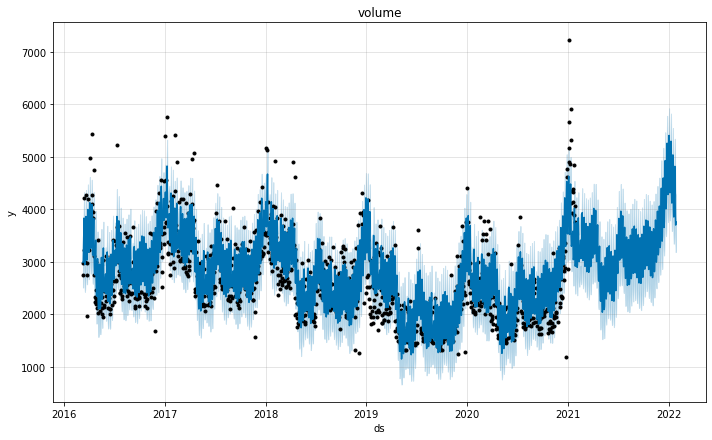


volume


,ds,yhat_lower,yhat,yhat_upper,volume,error_prophet,volume_forecast,error_forecast,diff,mape_forecast,mape_prophet
0,2021-02-01,3213.829760,3741.036903,4228.246597,4933.0,1192.0,4905.0,28.0,-1164.0,0.567606,24.163047
1,2021-02-02,2770.191871,3225.172695,3775.581567,4130.0,905.0,4703.0,573.0,-332.0,13.874092,21.908651
2,2021-02-03,2547.085711,3000.668302,3536.584519,3412.0,411.0,4133.0,721.0,310.0,21.131301,12.055442
3,2021-02-04,2360.249062,2892.793002,3369.897983,3081.0,188.0,3860.0,779.0,591.0,25.283999,6.108633
4,2021-02-05,2466.672473,2945.170116,3448.467872,2884.0,61.0,3726.0,842.0,781.0,29.195562,2.121016
5,2021-02-08,3309.702030,3835.306151,4322.819342,4176.0,341.0,4536.0,360.0,19.0,8.620690,8.158378
6,2021-02-09,2823.752756,3326.932175,3800.038759,3342.0,15.0,4034.0,692.0,677.0,20.706164,0.450863
7,2021-02-10,2607.804672,3107.245867,3619.152073,2709.0,398.0,3548.0,839.0,441.0,30.970838,14.700844
8,2021-02-11,2524.497912,3001.550816,3519.065078,2528.0,474.0,3247.0,719.0,245.0,28.441456,18.732232
9,2021-02-12,2525.840044,3053.549508,3581.783797,2377.0,677.0,3275.0,898.0,221.0,37.778713,28.462327


100%|██████████| 1/1 [00:06<00:00,  6.28s/it]


,volume
old model,18.536627
prophet,17.714664
difference,0.821963


CPU times: user 5.63 s, sys: 3.21 s, total: 8.84 s
Wall time: 6.3 s


In [4]:
#  @title Forecasting Tool

%%time

file_path_dict = {'WISE': '../content/WISE-Contractual_aht_vol.csv',
'CS-Alaska': '../content/CS-Alaska_aht_vol.csv',
'CS-John-Hancock': '../content/CS-John-Hancock_aht_vol.csv',
'CS-Maryland': '../content/CS-Maryland_aht_vol.csv',
 'CS-National': '../content/CS-National_aht_vol.csv',
 'RIS': '../content/RIS_aht_vol.csv',
 'RCS-PHONES': '../content/RCS-PHONES_aht_vol.csv',
'BRO': '../content/BRO_aht_vol.csv',
'PSG':  '../content/PSG_aht_vol.csv',
'BRO-Complex':  '../content/BRO-Complex_aht_vol.csv'}

name_dict = {v:k for k,v in file_path_dict.items()}

business_unit = 'RIS' #@param ['WISE', 'CS-Alaska', 'CS-John-Hancock', 'CS-Maryland', 'CS-National', 'RIS', 'RCS-PHONES', 'BRO', 'PSG', 'BRO-Complex']
kpi = 'volume'  #@param ['volume','aht','handle_time', 'abandonment_rate']
start_train = '2016-03-10' #@param {type:"date"}
end_train = '2021-02-01' #@param {type:"date"}
start_test = '2021-02-01' #@param {type:"date"}
end_test = '2021-03-04' #@param {type:"date"}
metric = 'mape' #@param ['mape', 'mae', 'rmse']
ci = 0.95 #@param {type:"number"}
train_with_holidays = False #@param {type:"boolean"}
data = file_path_dict[business_unit]


# if business_unit != 'RIS':
#     start_train = '2019-01-01' 

performance = get_performance(name_dict, data, [kpi], 
                              start_train, end_train, start_test, 
                              end_test, metric, ci=ci, train_holidays=train_with_holidays)

# The predictions tool below returns rolling forecasts

You can adjust the frequency of the predictions to weekly, monthly, bi-weekly, every 3,6 or 12 weeks, quarterly, or every 6 months, and a number of other inputs.

In [5]:
#  @title Predictions Tool
import os
def get_rolling_forecast(path, kpi, frequency='M'):
    preds = pd.read_csv(path, index_col=0, parse_dates=['ds'])
    preds.index = preds['ds']
    p = preds.resample(frequency).sum()

    names = path.split(kpi)
    
    folder = '../content/rolling_forecasts/'

    p['mape_forecast'] = (p[kpi] - p[kpi+'_forecast']).abs() / p[kpi] * 100
    p['mape_prophet'] = (p[kpi] - p['yhat']).abs() / p[kpi] * 100
    
    display(p[['yhat', kpi, kpi+'_forecast', 'mape_forecast', 'mape_prophet']])
    os.makedirs(folder, exist_ok=True)
    # p.to_csv(folder+'{}_{}_{}_{}.csv'.format(kpi, frequency, names[3], names[4]))
    print('*'*100)
    print(frequency+'\n')
    # print('{} trained on {} to {}'.format(kpi, names[1], names[2]))
    # print('tested on {} to {}'.format(names[3], names[4]))
    print('MAPE:', mean_absolute_percentage_error(p[kpi], p['yhat']))
    print('RMSE:', np.sqrt(mean_squared_error(p[kpi], p['yhat'])))

    return p[['yhat', kpi, kpi+'_forecast', 'mape_forecast', 'mape_prophet']] 

frequency = 'MS' #@param ['M', '6M', 'W', '2W', '3W', '6W', '12W', 'Q'] {allow-input: true}
path = 'volume_2016-03-10_2020-06-01_2020-06-01_2021-02-25_RIS.csv'
folder = '../content/predictions/'
kpi = 'volume' #@param ['volume', 'handle_time', 'aht']

results = []
for path in os.listdir(folder):
    prophet = get_rolling_forecast(folder+path, kpi, frequency=frequency)
    results.append(prophet)



,yhat,volume,volume_forecast,mape_forecast,mape_prophet
ds,,,,,
2021-02-01,61446.004207,57742.0,66099.0,14.473001,6.414749
2021-03-01,10196.959403,12891.0,9578.0,25.700101,20.898616


****************************************************************************************************
MS

MAPE: 13.656682393884187
RMSE: 3238.634118097758


In [6]:
monthly = pd.read_csv('monthly_volume.csv')
monthly = monthly.set_index('Date')


In [7]:
display(monthly)

,1,2,3,4,5,6,7,8,9
Date,,,,,,,,,
2020-05,-0.173113,-0.208990,-0.208990,-0.208990,-0.208990,-0.208990,-0.208990,NaN,NaN
2020-06,0.231401,0.170448,0.156627,0.156627,0.156627,0.156627,0.156627,0.156627,NaN
2020-07,0.100838,0.079132,0.079132,-0.002541,-0.002541,-0.002541,-0.002541,-0.002541,-0.002541
2020-08,0.084961,0.084961,0.001749,0.001749,-0.029116,-0.029116,-0.029116,-0.029116,-0.029116
2020-09,0.215224,0.215224,0.215224,0.146734,0.146734,0.120351,0.120351,0.120351,0.120351
2020-10,0.213567,0.213567,0.213567,0.213567,0.136807,0.136807,0.110104,0.110104,0.110104
2020-11,0.154726,0.154726,0.154726,0.154726,0.154726,0.130969,0.130969,0.104097,0.104097
2020-12,0.265589,0.265589,0.265589,0.265589,0.265589,0.265589,0.243726,0.243726,0.243726
2021-01,0.376221,0.376221,0.376221,0.376221,0.376221,0.376221,0.388935,0.388935,0.388935


In [8]:
m = pd.DataFrame(np.diag(monthly), index=monthly.index, columns=['monthly'])

In [9]:
prophet = prophet['2020-06':'2021-02']

In [10]:
prophet.index.rename('ds', inplace=True)

In [11]:
prophet

,yhat,volume,volume_forecast,mape_forecast,mape_prophet
ds,,,,,
2021-02-01,61446.004207,57742.0,66099.0,14.473001,6.414749


In [12]:
pd.DataFrame(np.diag(monthly), index=monthly.index)

,0
Date,
2020-05,-0.173113
2020-06,0.170448
2020-07,0.079132
2020-08,0.001749
2020-09,0.146734
2020-10,0.136807
2020-11,0.130969
2020-12,0.243726
2021-01,0.388935


In [13]:
prophet['mape_erlang'] = np.diag(monthly.copy())

ValueError: ignored

In [ ]:
prophet['mape_erlang'] = (prophet['mape_erlang'] * 100).abs()

In [ ]:
prophet

In [ ]:
p['mape_prophet'].mean(), p['mape_erlang'].mean()

# Upload ARIMA results and compare

In [ ]:
arima = pd.read_csv('results_volume.csv')
arima = arima.loc[:8,:]
scores = pd.concat([prophet.reset_index(), arima['mape']],1)
scores.rename(columns={'mape': 'mape_arima'}, inplace=True)
display(scores)


In [ ]:
scores[['mape_prophet',	'mape_erlang', 'mape_arima']].describe()

# test monthly forecast

Prophet does not forecast monthly aggregates well